This files contains an example of tuning a Random Forest model with BayesSearchCV

It saves the BayesSearchCV object to the `cross-validation.pkl`

In [1]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

%matplotlib inline

# Load Data

In [2]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)

In [3]:
hlp.pandas.numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,760,40,5.0%,0,0.0%,21.0,11.7,0.6,1.0,0.6,4.0,9.0,12.0,18.0,24.0,36.0,60.0
credit_amount,800,0,0.0%,38,5.0%,"3,203.9","2,932.3",0.9,1.9,3.9,0.0,753.9,"1,300.8","2,236.5","3,951.5","7,394.6","18,424.0"
installment_commitment,800,0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,800,0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,800,0,0.0%,0,0.0%,35.6,11.4,0.3,1.0,0.7,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,800,0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,800,0,0.0%,0,0.0%,1.1,0.3,0.3,2.0,2.1,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [4]:
hlp.pandas.non_numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,763,37,4.6%,no checking,4,0.5%
credit_history,800,0,0.0%,existing paid,5,0.6%
purpose,800,0,0.0%,radio/tv,10,1.2%
savings_status,800,0,0.0%,<100,5,0.6%
employment,800,0,0.0%,1<=X<4,5,0.6%
personal_status,800,0,0.0%,male single,4,0.5%
other_parties,800,0,0.0%,none,3,0.4%
property_magnitude,800,0,0.0%,car,4,0.5%
other_payment_plans,800,0,0.0%,none,3,0.4%
housing,800,0,0.0%,own,3,0.4%


In [5]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [6]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [7]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

# Transformation Pipeline

In [8]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [9]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [10]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('impute', hlp.sklearn_pipeline.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaling', hlp.sklearn_pipeline.TransformerChooser()),
])

In [11]:
non_numeric_pipeline = Pipeline([
    ('encoder', hlp.sklearn_pipeline.TransformerChooser()),
])

In [12]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('non_numeric', non_numeric_pipeline, non_numeric_columns)
])

# Model

In [13]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

In [14]:
full_pipeline = Pipeline([
    ('prep', transformations_pipeline),
    ('model', random_forest_model)
])

In [15]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('impute',
                                                   TransformerChooser()),
                                                  ('scaling',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric',
                                  Pipeline(steps=[('encoder',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                                   'personal_status', 'other_parties',
     

# skopt.BayesSearchCV

[https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [16]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score  # , roc_auc_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [17]:
num_folds = 5
num_repeats = 2

In [18]:
new_param_column_names = {'model | max_features': 'max_features',
                          'model | n_estimators': 'n_estimators',
                          'prep | non_numeric | encoder | transformer': 'encoder',
                          'prep | numeric | impute | transformer': 'imputer',
                          'prep | numeric | scaling | transformer': 'scaler'}

In [19]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedKFold

In [20]:
search_space = {
    'prep__numeric__impute__transformer': Categorical([SimpleImputer(strategy='mean')]),
    'prep__numeric__scaling__transformer': Categorical([MinMaxScaler(), StandardScaler()]),
    'prep__non_numeric__encoder__transformer': Categorical([
        OneHotEncoder(),
        hlp.sklearn_pipeline.CustomOrdinalEncoder()
    ]),
    'model__n_estimators': Integer(50, 5000),
    # If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
    'model__max_features':  Real(.01, .99),
}

bayes_search = BayesSearchCV(
    estimator=full_pipeline,
    search_spaces=search_space,
    n_iter=30,
    cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
    scoring='roc_auc',
    #return_train_score=True,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)
bayes_search.fit(X_train, y_train)

del search_space

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [21]:
print(bayes_search.cv_results_)

{'mean_fit_time': array([ 8.60759182, 18.35172846, 14.5569983 ,  3.02192597,  7.04998052,
       18.70175941, 13.89141953, 15.62354853, 11.99873197,  7.50976667,
        0.17357767,  9.38408937,  5.65501699,  0.16592031,  6.22505648,
        0.3053241 ,  4.68567774, 16.80604911,  6.48140996,  7.61427045,
       10.25811355,  9.63630381,  7.53664906, 11.10789251,  9.02226577,
        0.33562953,  9.4998445 ,  8.34137592,  8.30572567,  8.14598608]), 'std_fit_time': array([1.96500576, 3.65961877, 3.21670472, 0.63270669, 1.43047822,
       4.12802045, 3.02819838, 3.36119214, 2.63613751, 1.73478017,
       0.02638694, 2.27197448, 1.30738716, 0.02131164, 1.45663071,
       0.03651031, 1.00178695, 3.46981557, 1.54341256, 1.64658966,
       2.86516566, 2.15362391, 1.56250149, 2.32718358, 2.06425967,
       0.05242957, 1.7322598 , 1.81212331, 1.81984661, 1.82378181]), 'mean_score_time': array([0.59393764, 0.68147011, 0.68082447, 0.15175865, 0.34164119,
       0.7210505 , 0.55072856, 0.75155163,

In [22]:
bayes_search.cv

RepeatedKFold(n_repeats=2, n_splits=5, random_state=None)

In [30]:
bayes_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__max_features', 'param_model__n_estimators', 'param_prep__non_numeric__encoder__transformer', 'param_prep__numeric__impute__transformer', 'param_prep__numeric__scaling__transformer', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [87]:
[x for x in bayes_search.cv_results_.keys() if x.startswith('param_')]

['param_model__max_features',
 'param_model__n_estimators',
 'param_prep__non_numeric__encoder__transformer',
 'param_prep__numeric__impute__transformer',
 'param_prep__numeric__scaling__transformer']

In [88]:
parameter_names = [key for key, value in bayes_search.cv_results_['params'][0].items()]

['model__max_features',
 'model__n_estimators',
 'prep__non_numeric__encoder__transformer',
 'prep__numeric__impute__transformer',
 'prep__numeric__scaling__transformer']

In [65]:
[x for x in bayes_search.cv_results_['params'][0]]

['model__max_features',
 'model__n_estimators',
 'prep__non_numeric__encoder__transformer',
 'prep__numeric__impute__transformer',
 'prep__numeric__scaling__transformer']

In [78]:
def string_if_not_number(obj):
    if isinstance(obj, (int, float, complex)):
        return obj

    return str(obj)

In [ ]:
isinstance(x, (int, float, complex))

In [83]:
[index for index in range(len(bayes_search.cv_results_['params']))]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [94]:
parameter_name_mappings = {'model__max_features': 'max_features',
                           'model__n_estimators': 'n_estimators',
                           'prep__non_numeric__encoder__transformer': 'encoder',
                           'prep__numeric__impute__transformer': 'imputer',
                           'prep__numeric__scaling__transformer': 'scaler'}

[{'model__max_features': 'max_features'},
 {'model__n_estimators': 'n_estimators'},
 {'prep__non_numeric__encoder__transformer': 'encoder'},
 {'prep__numeric__impute__transformer': 'imputer'},
 {'prep__numeric__scaling__transformer': 'scaler'}]

In [ ]:
bayes_search.scoring

In [98]:
from helpsk.exceptions import HelpskParamValueError
import yaml

cv_results_name = 'cross_validation_run_1__bayes_search'
cv_results_description = "This is the first run of bayes search."
cv_results_dict = {'name': cv_results_name}
cv_results_dict['description'] = cv_results_description
cv_results_dict['higher_score_is_better'] = True

if isinstance(bayes_search.scoring, dict):
    score_names = list(bayes_search.scoring.keys())
elif isinstance(bayes_search.scoring, str):
    score_names = [bayes_search.scoring]
else:
    mess = 'The `searcher` does not have a string or dictionary .scoring property. Cannot extract '\
           'scores.'
    raise HelpskParamValueError(mess)

cv_results_dict['score_names'] = score_names
cv_results_dict['parameter-names'] = [key for key, value in bayes_search.cv_results_['params'][0].items()]
cv_results_dict['parameter-names-mapping'] = [{key: value} for key, value in parameter_name_mappings.items()]
cv_results_dict['times'] =  [{'mean_fit_time': bayes_search.cv_results_['mean_fit_time'].tolist()},
                            {'std_fit_time': bayes_search.cv_results_['std_fit_time'].tolist()},
                            {'mean_score_time': bayes_search.cv_results_['mean_score_time'].tolist()},
                            {'std_score_time': bayes_search.cv_results_['std_score_time'].tolist()}]
#cv_results_dict['parameter-iterations'] = {0: [{key: string_if_not_number(value)} for key, value in bayes_search.cv_results_['params'][0].items()]}
cv_results_dict['parameter-iterations'] = [{index: [{key: string_if_not_number(value)} for key, value in bayes_search.cv_results_['params'][index].items()]}
                                           for index in range(len(bayes_search.cv_results_['params']))]
with open('cross_validation_run_1__bayes_search.yaml', 'w') as file:
    documents = yaml.dump(cv_results_dict, file, default_flow_style=False, sort_keys=False)

In [46]:
import json

temp = json.dumps({'mean_fit_time': bayes_search.cv_results_['mean_fit_time'].tolist()})
with open('cross_validation_run_1__bayes_search.json', 'w', encoding='utf-8') as f:
    json.dump(temp, f, ensure_ascii=False, indent=4)


with open('cross_validation_run_1__bayes_search.json') as infile:
    d = json.load(infile)

d

'{"mean_fit_time": [8.607591819763183, 18.35172846317291, 14.556998300552369, 3.0219259738922117, 7.049980521202087, 18.70175940990448, 13.891419529914856, 15.623548531532288, 11.998731970787048, 7.509766674041748, 0.1735776662826538, 9.384089374542237, 5.655016994476318, 0.16592030525207518, 6.225056481361389, 0.3053241014480591, 4.6856777429580685, 16.80604910850525, 6.481409955024719, 7.614270448684692, 10.258113551139832, 9.636303806304932, 7.536649060249329, 11.107892513275146, 9.022265768051147, 0.3356295347213745, 9.49984450340271, 8.341375923156738, 8.30572566986084, 8.145986080169678]}'

## Results

In [23]:
print(bayes_search.cv.n_repeats)
print(bayes_search.cv.cvargs['n_splits'])

2
5


In [24]:
print(bayes_search.best_score_)
print(bayes_search.best_params_)

0.7714917147899578
OrderedDict([('model__max_features', 0.01), ('model__n_estimators', 5000), ('prep__non_numeric__encoder__transformer', CustomOrdinalEncoder()), ('prep__numeric__impute__transformer', SimpleImputer()), ('prep__numeric__scaling__transformer', MinMaxScaler())])


In [25]:
new_param_column_names

{'model | max_features': 'max_features',
 'model | n_estimators': 'n_estimators',
 'prep | non_numeric | encoder | transformer': 'encoder',
 'prep | numeric | impute | transformer': 'imputer',
 'prep | numeric | scaling | transformer': 'scaler'}

In [26]:
bayes_search_parsed = hlp.sklearn_eval.SearchCVParser(searcher=bayes_search,
                                                      higher_score_is_better = True,
                                                      new_param_column_names=new_param_column_names)

In [27]:
bayes_search_parsed.formatted_results()

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,max_features,n_estimators,encoder,scaler
0.771,0.746,0.797,0.010,"5,000",CustomOrdinalEncoder(),MinMaxScaler()
0.771,0.754,0.788,0.014,"4,098",CustomOrdinalEncoder(),StandardScaler()
0.769,0.750,0.788,0.010,"5,000",CustomOrdinalEncoder(),StandardScaler()
0.769,0.745,0.793,0.149,"4,169",CustomOrdinalEncoder(),MinMaxScaler()
0.767,0.735,0.798,0.010,"5,000",CustomOrdinalEncoder(),StandardScaler()
0.767,0.751,0.782,0.010,"3,043",CustomOrdinalEncoder(),MinMaxScaler()
0.766,0.733,0.798,0.010,"3,521",CustomOrdinalEncoder(),StandardScaler()
0.764,0.751,0.777,0.010,"4,271",CustomOrdinalEncoder(),MinMaxScaler()
0.763,0.730,0.796,0.010,"5,000",CustomOrdinalEncoder(),MinMaxScaler()
0.762,0.735,0.790,0.412,"3,652",CustomOrdinalEncoder(),StandardScaler()


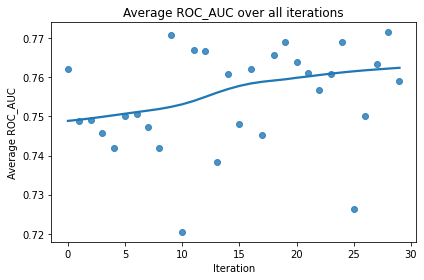

In [28]:
sns.regplot(x=np.arange(0, len(bayes_search_parsed.results)), y=bayes_search_parsed.results.sort_index()['roc_auc Mean'], lowess=True)
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()

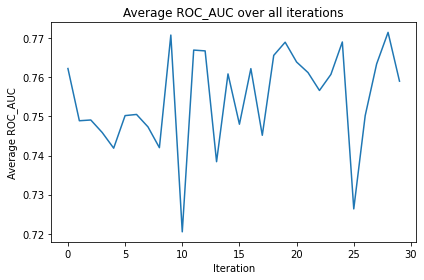

In [29]:
bayes_search_parsed.results.sort_index()['roc_auc Mean'].plot()
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()